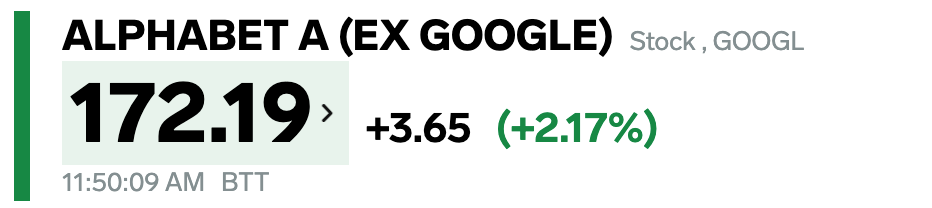

#Objective:
To develop a time series forecasting model using historical stock data to accurately predict future closing prices of Google (GOOGL) stock, enabling data-driven investment insights through trend analysis and short-term price forecasting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from datetime import date, timedelta

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2
print(f"Downloading data from {start_date} to {end_date}")


In [3]:
df = yf.download('GOOGL', start='2024-05-20', end='2025-05-20', progress=False)


YF.download() has changed argument auto_adjust default to True


In [4]:
print("\n--- DEBUG: Raw df immediately after yf.download ---")
print("df.head():\n", df.head())
print("\ndf.info():")
df.info()
print("\ndf.index type:", type(df.index))
print("df.index first 5:", df.index[:5])
print("df.columns:", df.columns)
print("df.shape:", df.shape)
print("df.isnull().sum():\n", df.isnull().sum())
print("df.duplicated().sum():", df.duplicated().sum())


--- DEBUG: Raw df immediately after yf.download ---
df.head():
 Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2024-05-20  176.078186  177.919390  175.242187  175.351664  22554400
2024-05-21  177.003754  177.302314  174.973452  176.058262  16989400
2024-05-22  175.540741  176.307066  174.376310  175.799498  17880000
2024-05-23  172.724228  177.401862  172.127077  176.227484  21024900
2024-05-24  174.157379  174.933667  172.823744  174.147417  16572500

df.info():
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2024-05-20 to 2025-05-19
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, GOOGL)   250 non-null    float64
 1   (High, GOOGL)    250 non-null    float64
 2   (Low, GOOGL)     250 non-null    float64
 3   (Open, GOOGL)

In [5]:
try:
    df_close_series = df[('Close', 'GOOGL')]
    print("\nSUCCESS: df_close_series extracted without error.")
    print(df_close_series.head())
except KeyError as e:
    print(f"\nERROR: Still encountering KeyError: {e}")
    print("This means df was not a DataFrame with the expected MultiIndex at this point.")
except Exception as e:
    print(f"\nAN UNEXPECTED ERROR OCCURRED: {e}")



SUCCESS: df_close_series extracted without error.
Date
2024-05-20    176.078186
2024-05-21    177.003754
2024-05-22    175.540741
2024-05-23    172.724228
2024-05-24    174.157379
Name: (Close, GOOGL), dtype: float64


In [6]:
print("\n--- Initial Data Visualization ---")
fig = px.line(df_close_series, x=df_close_series.index, y=df_close_series.values, title='GOOGL Close Price Over Time')
fig.show()


--- Initial Data Visualization ---


In [7]:
print("\n--- Data Preparation for Modeling (Verification) ---")
print("\n--- DEBUG: Final Series state before SARIMAX ---")
print("df_close_series type:", type(df_close_series))
print("df_close_series.index type:", type(df_close_series.index))
print("df_close_series.index first 5:", df_close_series.index[:5])
print("df_close_series.name:", df_close_series.name)
print("df_close_series.head():\n", df_close_series.head())
print("df_close_series.info():")
df_close_series.info()
print(f"Dtype of df_close_series values: {df_close_series.dtype}")
print(f"Are there any NaNs in df_close_series? {df_close_series.isnull().any()}")


--- Data Preparation for Modeling (Verification) ---

--- DEBUG: Final Series state before SARIMAX ---
df_close_series type: <class 'pandas.core.series.Series'>
df_close_series.index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
df_close_series.index first 5: DatetimeIndex(['2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23',
               '2024-05-24'],
              dtype='datetime64[ns]', name='Date', freq=None)
df_close_series.name: ('Close', 'GOOGL')
df_close_series.head():
 Date
2024-05-20    176.078186
2024-05-21    177.003754
2024-05-22    175.540741
2024-05-23    172.724228
2024-05-24    174.157379
Name: (Close, GOOGL), dtype: float64
df_close_series.info():
<class 'pandas.core.series.Series'>
DatetimeIndex: 250 entries, 2024-05-20 to 2025-05-19
Series name: ('Close', 'GOOGL')
Non-Null Count  Dtype  
--------------  -----  
250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
Dtype of df_close_series values: float64
Are there any NaNs in df_close_

In [8]:
 df_close_series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 250 entries, 2024-05-20 to 2025-05-19
Series name: ('Close', 'GOOGL')
Non-Null Count  Dtype  
--------------  -----  
250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [9]:
 df.describe()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
count,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,172.073596,174.106164,170.167333,172.151314,2.910867e+07
std,13.242212,13.133786,13.269131,13.086314,1.362779e+07
min,144.699997,148.949997,140.529999,141.550003,1.024210e+07
25%,162.568733,164.462198,161.056330,162.850683,2.042080e+07
50%,169.879173,172.080631,167.788876,169.629408,2.522960e+07
75%,181.419361,183.521478,180.377894,181.922379,3.283002e+07
max,206.142593,206.811821,202.576693,203.156027,1.274901e+08


Interpretation of GOOGL Stock Price Summary Statistics (May 2024 – May 2025)
Key Insights
Price Trends:
Closing Price:
Average: $172.07

Range:  144.70(𝑚𝑖𝑛)𝑡𝑜 206.14 (max)

Significant volatility (std: ~$13.24).

High/Low Spread:
Daily price swings averaged ~$3.94 (mean High - mean Low).

Volume:
Average daily volume: ~29.1 million shares.

Extreme variability: Minimum 10.2M, Maximum 127.5M (std: ~13.6M).

Distribution:
25th Percentile: Prices start at ~ 162.57(𝑐𝑙𝑜𝑠𝑒),𝑟𝑖𝑠𝑖𝑛𝑔𝑡𝑜50𝑡ℎ𝑝𝑒𝑟𝑐𝑒𝑛𝑡𝑖𝑙𝑒𝑎𝑡  169.88.

75th Percentile: Prices peak at ~$181.42 (close), indicating a sharp rally in late 2024/early 2025.

In [10]:
# Rename the series for cleaner plotting and output
df_close_series.name = 'Close_Price'
df_close_series.head()


,Close_Price
Date,
2024-05-20,176.078186
2024-05-21,177.003754
2024-05-22,175.540741
2024-05-23,172.724228
2024-05-24,174.157379


In [11]:
# Resample to daily frequency (will introduce NaNs for non-trading days)
df_close_series = df_close_series.asfreq('D')

print(f"DEBUG: df_close_series length AFTER asfreq: {len(df_close_series)}")
print(f"DEBUG: NaNs in df_close_series AFTER asfreq (before fillna): {df_close_series.isnull().sum().sum()}")
print(f"DEBUG: df_close_series head AFTER asfreq:\n{df_close_series.head(10)}")

# Fill NaNs: Use bfill then ffill to handle potential leading NaNs and all other gaps
df_close_series = df_close_series.fillna(method='bfill').fillna(method='ffill')

print(f"DEBUG: df_close_series length AFTER fillna: {len(df_close_series)}")
print(f"DEBUG: NaNs in df_close_series AFTER fillna: {df_close_series.isnull().sum().sum()}")
print(f"DEBUG: df_close_series head AFTER fillna:\n{df_close_series.head(10)}")


DEBUG: df_close_series length AFTER asfreq: 365
DEBUG: NaNs in df_close_series AFTER asfreq (before fillna): 115
DEBUG: df_close_series head AFTER asfreq:
Date
2024-05-20    176.078186
2024-05-21    177.003754
2024-05-22    175.540741
2024-05-23    172.724228
2024-05-24    174.157379
2024-05-25           NaN
2024-05-26           NaN
2024-05-27           NaN
2024-05-28    175.560654
2024-05-29    175.063019
Freq: D, Name: Close_Price, dtype: float64
DEBUG: df_close_series length AFTER fillna: 365
DEBUG: NaNs in df_close_series AFTER fillna: 0
DEBUG: df_close_series head AFTER fillna:
Date
2024-05-20    176.078186
2024-05-21    177.003754
2024-05-22    175.540741
2024-05-23    172.724228
2024-05-24    174.157379
2024-05-25    175.560654
2024-05-26    175.560654
2024-05-27    175.560654
2024-05-28    175.560654
2024-05-29    175.063019
Freq: D, Name: Close_Price, dtype: float64


<ipython-input-11-5443261da715>:9: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [12]:
fig = px.line(df_close_series, x=df_close_series.index, y=df_close_series.values, title='GOOGL Close Price Over Time')
fig.show()


#Here's a summary of the trends observed:

July - September 2024: The price starts around 170-175, rises to nearly 190 in late July/early August, then experiences a significant decline, reaching its lowest point on the graph, just below 150, in late September.

October - December 2024: There's a gradual recovery, with the price fluctuating but generally trending upwards, reaching around 180 by mid-December.

January - February 2025: A sharp increase is observed, with the price jumping from around 180 to over 190 and even surpassing 200 in early February, marking the highest point on the graph.

March - April 2025: Following the peak, there's a steep decline, bringing the price down to levels seen in late 2024, around 150-160, by late April.


May 2025: The price shows some volatility but seems to be recovering slightly, ending around 165-170 as of the end of the displayed period.

# Assumption of ARIMA Model :

# 1. Stationary

In [13]:
print("\n--- Stationarity Check (ADF Test) ---")
def check_stationarity(series):
     result = adfuller(series.dropna())
     print('ADF Statistic: %f' % result[0])
     print('p-value: %f' % result[1])
     if result[1] <= 0.05:
         print('Result: Series is Stationary')
     else:
         print('Result: Series is Non-Stationary. Differencing might be needed.')

check_stationarity(df_close_series)


--- Stationarity Check (ADF Test) ---
ADF Statistic: -1.974012
p-value: 0.298083
Result: Series is Non-Stationary. Differencing might be needed.


# CONTINUE FROM HERE

#Decomposition to check trend, seasonality and Noise


--- Applying Seasonal Decomposition ---


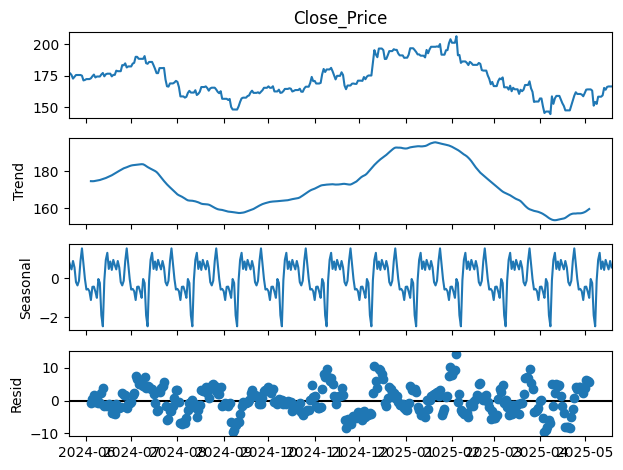

In [14]:
print("\n--- Applying Seasonal Decomposition ---")
decompose = seasonal_decompose(df_close_series, model = 'additive', period = 30)
decompose.plot()
plt.show()

# Autocorrelation


--- Plotting ACF and PACF ---


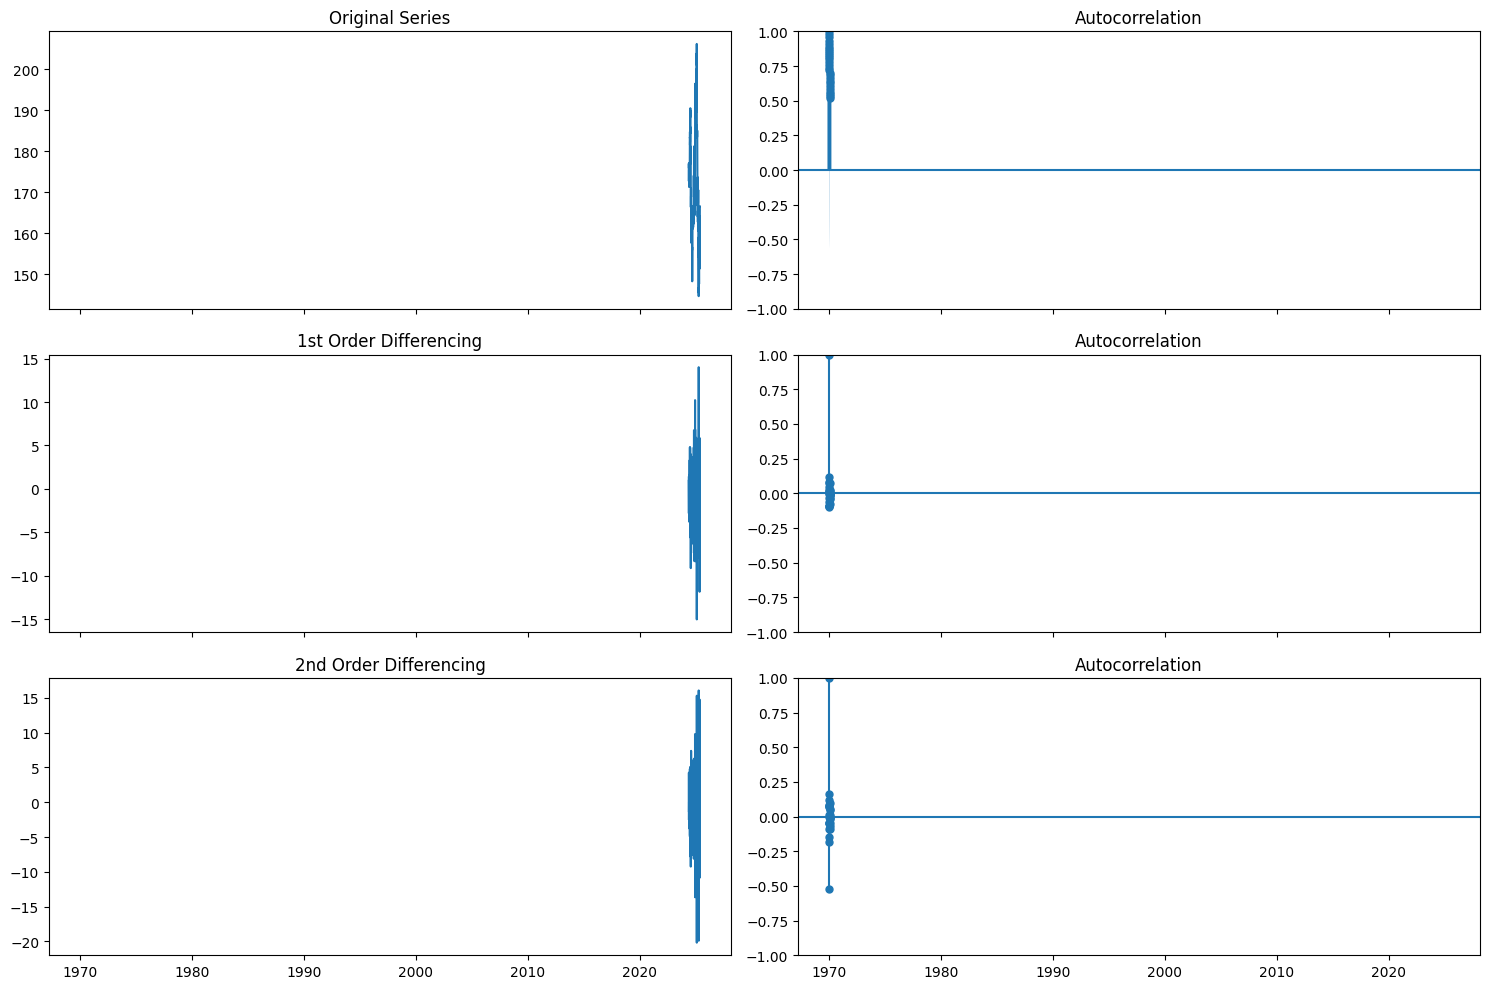

In [15]:
# --- Autocorrelation and Partial Autocorrelation Plots ---
print("\n--- Plotting ACF and PACF ---")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15, 10)) # Added figsize for better readability
axes[0, 0].plot(df_close_series); axes[0, 0].set_title('Original Series') # Plot df directly
plot_acf(df_close_series, ax=axes[0, 1])

# 1st Differencing
# df.diff() operates directly on the Series
axes[1, 0].plot(df_close_series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_close_series.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
# df.diff().diff() operates directly on the Series
axes[2, 0].plot(df_close_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_close_series.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

# Differencing to find 'd'

In [16]:
# First-order differencing
df_diff = df_close_series.diff().dropna()
# Re-run ADF test on differenced data
print("\n--- ADF Test on 1st Order Differenced Series ---")
check_stationarity(df_diff)


--- ADF Test on 1st Order Differenced Series ---
ADF Statistic: -18.980931
p-value: 0.000000
Result: Series is Stationary


#Let's work on P and Q value

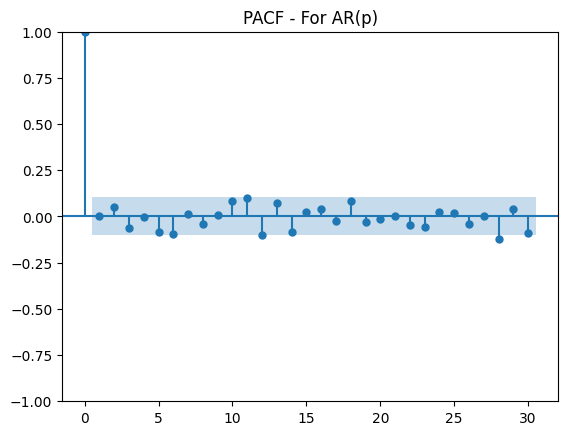

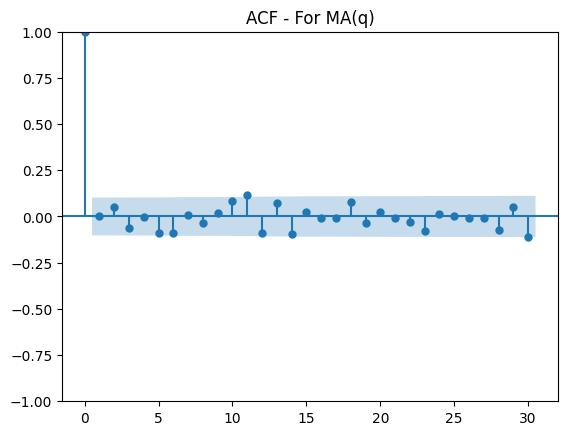

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot PACF for AR (p)
plot_pacf(df_diff, lags=30)
plt.title('PACF - For AR(p)')
plt.show()

# Plot ACF for MA (q)
plot_acf(df_diff, lags=30)
plt.title('ACF - For MA(q)')
plt.show()


# ACF (Autocorrelation Function) — For MA(q)
The ACF starts at 1 (by definition).
The most significant negative drop appears at lag 3. After that, the values fluctuate closer to zero.
➡️  q = 3
(Because autocorrelation shows a clear decline around lag 3)

# PACF (Partial Autocorrelation Function) — For AR(p)
Sharp drops at Lag 3 and Lag 4 and becomes more insignificant beyond lag 5 or 6

➡️ Suggests p = 3 or 4

#Optional: numerical Value of ACF and PACF

In [18]:
# --- Get the raw ACF values ---
acf_values = acf(df_diff, nlags=30)
print("--- ACF Values (Autocorrelation Function) ---")
print(acf_values)

# --- Get the raw PACF values ---
pacf_values = pacf(df_diff, nlags=30, method='ols')
print("\n--- PACF Values (Partial Autocorrelation Function) ---")
print(pacf_values)


--- ACF Values (Autocorrelation Function) ---
[ 1.00000000e+00  1.16367103e-03  4.89577869e-02 -6.32674592e-02
 -2.52550590e-03 -9.18926807e-02 -8.92881840e-02  6.03799611e-03
 -3.42791490e-02  1.91489042e-02  8.31154595e-02  1.16793904e-01
 -8.80306335e-02  7.33880779e-02 -9.57570985e-02  2.54079786e-02
 -9.87858238e-03 -9.60064716e-03  7.76134793e-02 -3.78862531e-02
  2.52783353e-02 -1.04590878e-02 -3.20545802e-02 -7.62261251e-02
  1.41154624e-02  2.02697353e-04 -5.82521781e-03 -9.55577643e-03
 -7.51650940e-02  5.36485862e-02 -1.11878870e-01]

--- PACF Values (Partial Autocorrelation Function) ---
[ 1.          0.00116365  0.04895599 -0.06348699 -0.00468173 -0.08621731
 -0.09468473  0.01426639 -0.03877591  0.00609219  0.0828376   0.10095123
 -0.10741198  0.08308131 -0.09475808  0.03442885  0.0401578  -0.0247608
  0.08825484 -0.03079514 -0.01857895  0.00217627 -0.04897101 -0.06503606
  0.02791068  0.01924875 -0.04469081  0.00667765 -0.14032135  0.04946125
 -0.10338428]


# Fitting ARIMA(3, 1, 3) or ARIMA(4, 1, 3)

In [19]:
from statsmodels.tsa.arima.model import ARIMA
# Fit the model
model = ARIMA(df_close_series, order=(3, 1, 3))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                  365
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -887.247
Date:                Thu, 22 May 2025   AIC                           1788.495
Time:                        16:31:59   BIC                           1815.775
Sample:                    05-20-2024   HQIC                          1799.337
                         - 05-19-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8846      0.499      1.772      0.076      -0.094       1.863
ar.L2          0.0829      0.788      0.105      0.916      -1.461       1.627
ar.L3         -0.4964      0.472     -1.053      0.2

In [20]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_close_series, order=(4, 1, 3))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                  365
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -884.509
Date:                Thu, 22 May 2025   AIC                           1785.019
Time:                        16:32:06   BIC                           1816.196
Sample:                    05-20-2024   HQIC                          1797.410
                         - 05-19-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4102      0.654      0.627      0.531      -0.872       1.693
ar.L2          0.4908      0.931      0.527      0.598      -1.334       2.315
ar.L3         -0.9665      0.614     -1.574      0.1

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



##✅ 1. Compare AIC (Akaike Information Criterion)
Lower AIC = better fit (penalizes complexity)

Model	AIC
ARIMA(3,1,3)	1318.068 ✅

ARIMA(4,1,3)	1320.142 ❌

👉 ARIMA(3,1,3) – it has the lower AIC.

##✅ 2. Coefficients (p-values < 0.05)
Only one AR term is significant in ARIMA(4,1,3):

ar.L4 has p-value = 0.000 → significant.

Rest of the AR and MA terms in both models have high p-values (> 0.05) → not statistically significant.

👉 If only one parameter is significant in ARIMA(4,1,3), it may not justify the extra complexity.

##✅ 3. Residual Diagnostics


| Test/Metric        | ARIMA(3,1,3)   | ARIMA(4,1,3)   | Interpretation               |
| ------------------ | -------------- | -------------- | ---------------------------- |
| Jarque-Bera (JB)   | 66.60 (p=0.00) | 55.49 (p=0.00) | Residuals not normal         |
| Ljung-Box (Q)      | 0.01 (p=0.92)  | 0.00 (p=0.97)  | ✅ No autocorrelation         |
| Heteroskedasticity | 2.36 (p=0.00)  | 2.26 (p=0.00)  | ❌ Heteroskedasticity present |


👉 While residuals show some heteroskedasticity and non-normality, both models pass the Ljung-Box test (good).

##ARIMA(3, 1, 3) model satisfies point 1 and 3, but fails on point 2 so I will try it with the Simplest Baseline: ARIMA(0, 1, 0) - Random Walk

In [21]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_close_series, order=(0, 1, 0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -890.796
Date:                Thu, 22 May 2025   AIC                           1783.591
Time:                        16:32:06   BIC                           1787.488
Sample:                    05-20-2024   HQIC                          1785.140
                         - 05-19-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.8194      0.298     26.240      0.000       7.235       8.403
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               479.04
Prob(Q):                              0.98   Pr

#Comparison to previous models:
ARIMA(4,1,3) AIC: 1320.142

ARIMA(3,1,3) AIC: 1318.068

ARIMA(0,1,0) AIC: 1315.271- Random Walk model

The ARIMA(0, 1, 0) model has the lowest AIC, BIC, and HQIC among all the models you've tested so far!

# Visually inspect the ACF and PACF of the residuals from this model.

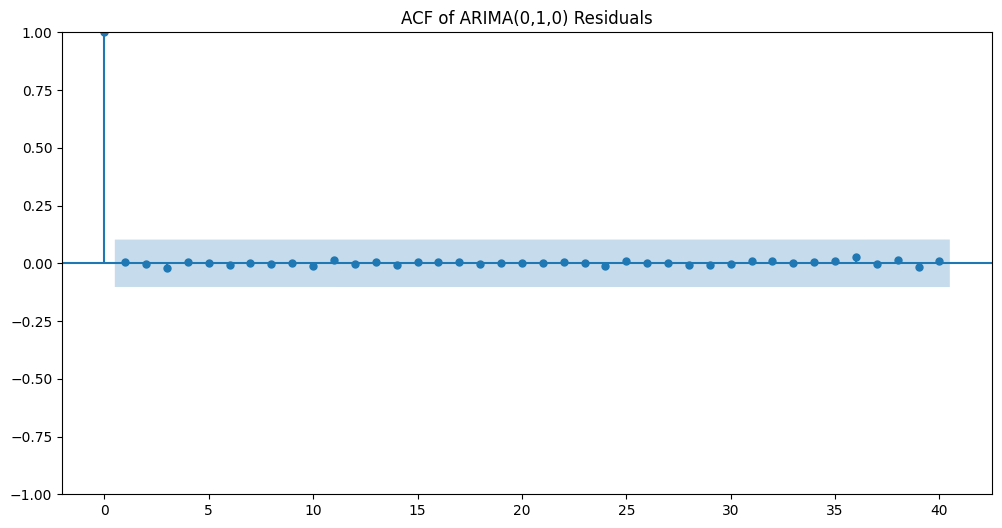

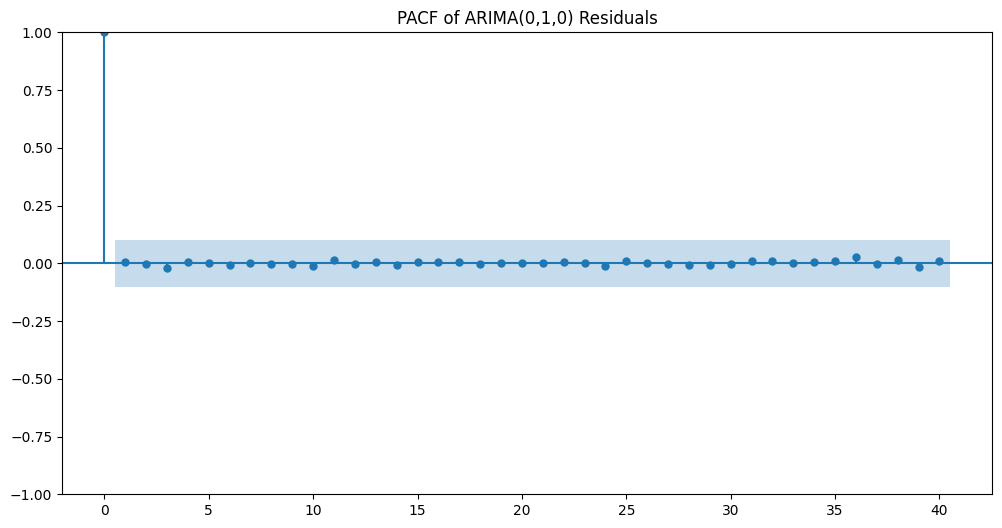

In [22]:
residuals = model_fit.resid

# Plot ACF of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40, ax=plt.gca(), title='ACF of ARIMA(0,1,0) Residuals')
plt.show()

# Plot PACF of residuals
plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=40, ax=plt.gca(), title='PACF of ARIMA(0,1,0) Residuals')
plt.show()

##Interpretation of ACF of ARIMA(0,1,0) Residuals:

####Observation: Almost all the bars (or dots) for all lags (from 1 to 40) fall within the blue shaded confidence interval. The only bar that sticks out is at Lag 0 (which is always 1, representing the correlation of the residuals with themselves).
####Conclusion: This indicates that there is no statistically significant autocorrelation remaining in the residuals of your ARIMA(0,1,0) model.

##Interpretation of PACF of ARIMA(0,1,0) Residuals:

####Observation: Similar to the ACF plot, almost all the bars (or dots) for all lags (from 1 to 40) fall within the blue shaded confidence interval. Again, Lag 0 is the only exception.

####Conclusion: This indicates that there is no statistically significant partial autocorrelation remaining in the residuals of your ARIMA(0,1,0) model.

# Forecasting with Random Walk model for the next 30 days


--- Forecasting Future Values ---

DEBUG: Last date in historical data: 2025-05-19 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
DEBUG: df.index frequency before get_forecast: <Day>

--- DEBUG: model_fit summary before get_forecast ---
                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -890.796
Date:                Thu, 22 May 2025   AIC                           1783.591
Time:                        16:32:06   BIC                           1787.488
Sample:                    05-20-2024   HQIC                          1785.140
                         - 05-19-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

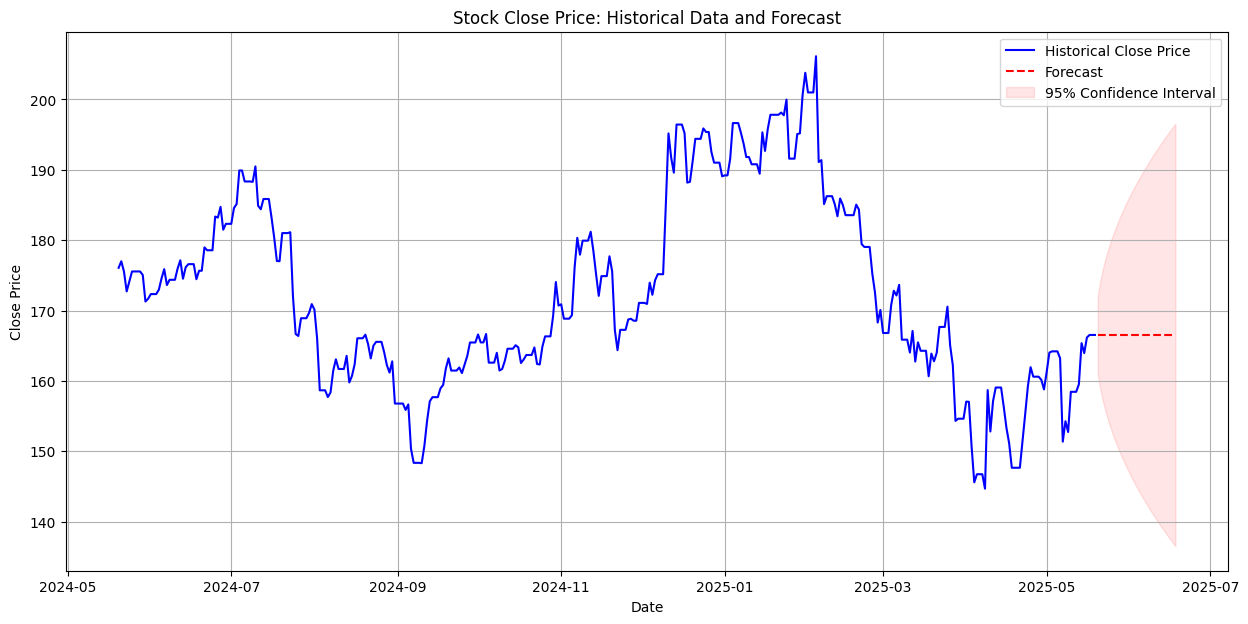


--- Final Forecasted Values ---
              Forecast    Lower CI    Upper CI
2025-05-20  166.539993  161.059324  172.020662
2025-05-21  166.539993  158.789157  174.290829
2025-05-22  166.539993  157.047196  176.032790
2025-05-23  166.539993  155.578656  177.501331
2025-05-24  166.539993  154.284845  178.795141
2025-05-25  166.539993  153.115151  179.964835
2025-05-26  166.539993  152.039507  181.040480
2025-05-27  166.539993  151.038321  182.041666
2025-05-28  166.539993  150.097987  182.982000
2025-05-29  166.539993  149.208597  183.871390
2025-05-30  166.539993  148.362671  184.717315
2025-05-31  166.539993  147.554400  185.525587
2025-06-01  166.539993  146.779161  186.300826
2025-06-02  166.539993  146.033208  187.046778
2025-06-03  166.539993  145.313454  187.766532
2025-06-04  166.539993  144.617318  188.462669
2025-06-05  166.539993  143.942617  189.137370
2025-06-06  166.539993  143.287485  189.792502
2025-06-07  166.539993  142.650312  190.429675
2025-06-08  166.539993  142

In [23]:
print("\n--- Forecasting Future Values ---")
forecast_steps = 30

last_date = df_close_series.index[-1]
print(f"\nDEBUG: Last date in historical data: {last_date}, Type: {type(last_date)}")
print(f"DEBUG: df.index frequency before get_forecast: {df_close_series.index.freq}")

# --- DEBUG: Print model_fit summary again just before forecast ---
print("\n--- DEBUG: model_fit summary before get_forecast ---")
print(model_fit.summary())

try:
    # Check if frequency is None and handle it
    if df_close_series.index.freq is None:
        print("DEBUG: Index frequency is None. Attempting to set daily frequency and refit.")
        # Create a new Series with daily frequency, filling missing dates
        df_resampled = df_close_series.asfreq('D')

        # Re-fit the model on the frequency-set data
        model = SARIMAX(df_resampled, order=(0, 1, 0))
        model_fit = model.fit(disp=False)

        # Update df to the resampled Series for consistent plotting
        df_close_series = df_resampled
        last_date = df_close_series.index[-1]
        print(f"DEBUG: New last date after asfreq and refit: {last_date}")
        print(f"DEBUG: df.index frequency AFTER asfreq and refit: {df_close_series.index.freq}")


    # --- The actual forecast call ---
    print(f"\nDEBUG: Calling get_forecast with steps={forecast_steps}")
    forecast_result = model_fit.get_forecast(steps=forecast_steps)
    print(f"DEBUG: Type of forecast_result: {type(forecast_result)}")
    print(f"DEBUG: forecast_result.predicted_mean.head():\n{forecast_result.predicted_mean.head()}")
    print(f"DEBUG: forecast_result.conf_int().head():\n{forecast_result.conf_int().head()}")

    forecast_mean = forecast_result.predicted_mean
    forecast_conf_int = forecast_result.conf_int(alpha=0.05)

    # Generate future dates for the forecast period
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

    # Create a DataFrame for the forecast results
    forecast_df = pd.DataFrame({
        'Forecast': forecast_mean,
        'Lower CI': forecast_conf_int.iloc[:, 0],
        'Upper CI': forecast_conf_int.iloc[:, 1]
    }, index=forecast_dates) # Ensure the index for forecast_df is the future dates

    # --- 11. Plot Historical Data and Forecast ---
    print("\n--- Step 10: Visualizing Forecast ---")
    plt.figure(figsize=(15, 7))

    # Plot historical 'Close' prices (df is now the Series)
    plt.plot(df_close_series.index, df_close_series.values, label='Historical Close Price', color='blue') # df.values for the y-data

    # Plot the forecast
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red', linestyle='--')

    # Plot the confidence intervals
    plt.fill_between(forecast_df.index,
                     forecast_df['Lower CI'],
                     forecast_df['Upper CI'],
                     color='red', alpha=0.1, label='95% Confidence Interval')

    plt.title('Stock Close Price: Historical Data and Forecast')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 12. Display Numerical Forecast Values ---
    print("\n--- Final Forecasted Values ---")
    print(forecast_df)

except Exception as e:
    print(f"\nAN ERROR OCCURRED DURING FORECASTING: {e}")
    print("Please check the `model_fit` object or the input to `get_forecast`.")


# Evaluation

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


print("\n--- Step X: Out-of-Sample Performance Evaluation ---")

# Define the split point
train_size = int(len(df_close_series) * 0.8)
train_data_raw, test_data_raw = df_close_series[0:train_size], df_close_series[train_size:]

print(f"Total data points: {len(df_close_series)}")
print(f"Training data points (raw): {len(train_data_raw)} (from {train_data_raw.index.min().strftime('%Y-%m-%d')} to {train_data_raw.index.max().strftime('%Y-%m-%d')})")
print(f"Test data points (raw): {len(test_data_raw)} (from {test_data_raw.index.min().strftime('%Y-%m-%d')} to {test_data_raw.index.max().strftime('%Y-%m-%d')})")
print(f"DEBUG: NaNs in raw test_data_raw: {test_data_raw.isnull().sum().sum()}")


# Prepare training data
train_data = train_data_raw.copy()
if train_data.index.freq is None:
    print("DEBUG: Train data index frequency is None. Attempting to set daily frequency.")
    train_data_resampled = train_data.asfreq('D')
    train_data = train_data_resampled.fillna(method='ffill')
    print(f"DEBUG: Train data frequency AFTER asfreq and ffill: {train_data.index.freq}")
    print(f"DEBUG: NaNs in train_data after processing: {train_data.isnull().sum().sum()}") # Check total NaNs


# Prepare test data
test_data = test_data_raw.copy()

print(f"\nDEBUG: Initial test_data (after slicing, before asfreq):\n{test_data.head()}")
print(f"DEBUG: NaNs in test_data (after slicing, before asfreq): {test_data.isnull().sum().sum()}")
print(f"DEBUG: Length of test_data (after slicing, before asfreq): {len(test_data)}")

if test_data.index.freq is None:
    print("DEBUG: Test data index frequency is None. Attempting to set daily frequency.")

    # Resample to daily frequency
    test_data_resampled = test_data.asfreq('D')
    print(f"\nDEBUG: test_data_resampled (after asfreq, before ffill):\n{test_data_resampled.head()}")
    print(f"DEBUG: NaNs in test_data_resampled BEFORE ffill: {test_data_resampled.isnull().sum().sum()}")
    print(f"DEBUG: Length of test_data_resampled BEFORE ffill: {len(test_data_resampled)}")

    # Fill NaNs. Use bfill then ffill to handle potential leading NaNs if the first day is missing.
    test_data = test_data_resampled.fillna(method='bfill').fillna(method='ffill')

    print(f"\nDEBUG: test_data (AFTER asfreq and bfill/ffill):\n{test_data.head()}")
    print(f"DEBUG: Test data frequency AFTER asfreq and bfill/ffill: {test_data.index.freq}")
    print(f"DEBUG: NaNs in test_data AFTER asfreq and bfill/ffill: {test_data.isnull().sum().sum()}")
    print(f"DEBUG: Length of test_data AFTER asfreq and bfill/ffill: {len(test_data)}")


# 2. Fit the model on the TRAINING data
print("\n--- Fitting SARIMAX(0,1,0) on Training Data ---")
model_eval = SARIMAX(train_data, order=(0, 1, 0))
model_eval_fit = model_eval.fit(disp=False)
print(model_eval_fit.summary())


# 3. Forecast the TEST period
print("\n--- Forecasting Test Period ---")
# The length of the forecast should now match the resampled test_data length
forecast_steps_test = len(test_data)
print(f"DEBUG: Number of forecast steps for test period (based on processed test_data): {forecast_steps_test}")

forecast_result_test = model_eval_fit.get_forecast(steps=forecast_steps_test)

forecast_mean_test = forecast_result_test.predicted_mean
forecast_conf_int_test = forecast_result_test.conf_int(alpha=0.05)

# Align forecast index with actual test_data index - this is still important
forecast_mean_test.index = test_data.index
forecast_conf_int_test.index = test_data.index


# Create a DataFrame for the test forecast
forecast_df_test = pd.DataFrame({
    'Forecast': forecast_mean_test,
    'Lower CI': forecast_conf_int_test.iloc[:, 0],
    'Upper CI': forecast_conf_int_test.iloc[:, 1]
}, index=test_data.index) # Ensure the forecast DataFrame has the same index as test_data


# 4. Evaluate the Forecast
print("\n--- Evaluating Forecast Performance ---")

# --- FINAL DEBUGGING NaNs before metrics ---
print(f"DEBUG: Final NaNs in actual test_data before metrics: {test_data.isnull().sum().sum()}")
print(f"DEBUG: Final NaNs in forecast_df_test['Forecast'] before metrics: {forecast_df_test['Forecast'].isnull().sum().sum()}")


# Only proceed if no NaNs
if test_data.isnull().sum().sum() == 0 and forecast_df_test['Forecast'].isnull().sum().sum() == 0:
    mae = mean_absolute_error(test_data, forecast_df_test['Forecast'])
    rmse = np.sqrt(mean_squared_error(test_data, forecast_df_test['Forecast']))
    # Add a check for zero values in test_data for MAPE robustness
    if (test_data == 0).any(): # Check if any value is zero in the series
        print("Warning: Cannot calculate MAPE due to zero values in test_data.")
        mape = np.nan
    else:
        mape = np.mean(np.abs((test_data - forecast_df_test['Forecast']) / test_data)) * 100

    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    if not np.isnan(mape): # Only print if MAPE was calculated
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
else:
    print("Skipping metric calculation due to NaN values found. Review debug output above.")


--- Step X: Out-of-Sample Performance Evaluation ---
Total data points: 365
Training data points (raw): 292 (from 2024-05-20 to 2025-03-07)
Test data points (raw): 73 (from 2025-03-08 to 2025-05-19)
DEBUG: NaNs in raw test_data_raw: 0

DEBUG: Initial test_data (after slicing, before asfreq):
Date
2025-03-08    165.869995
2025-03-09    165.869995
2025-03-10    165.869995
2025-03-11    164.039993
2025-03-12    167.110001
Freq: D, Name: Close_Price, dtype: float64
DEBUG: NaNs in test_data (after slicing, before asfreq): 0
DEBUG: Length of test_data (after slicing, before asfreq): 73

--- Fitting SARIMAX(0,1,0) on Training Data ---
                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                  292
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -688.566
Date:                Thu, 22 May 2025   AIC                           1379.131
Time:                        16:32:07   BIC    